#AI PPT Builder

In [1]:
!pip install -q langchain langchain-google-genai langchain_core langchain_community

In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [3]:
from pydantic import BaseModel, Field
from typing import List

class SlideSchema(BaseModel):
    title: str = Field(..., title="Title", description="The title of the Slide.")
    content: str = Field(..., title="Content", description="The content of the slide.")

    model_config = {
        "json_schema_extra": {
            "examples": """
                "title": "Introduction",
                "content": "This slide introduces the main topics of the presentation.",
                """
        }
    }


class PPTFileSchema(BaseModel):
    title: str = Field(..., title="Title", description="The title of the PowerPoint presentation.")
    description: str = Field(..., title="Description", description="A brief description of the PowerPoint presentation.")
    slides: List[SlideSchema] = Field(..., title="Slides", description="A list of slides in the PowerPoint presentation.")

    model_config = {
      "json_schema_extra": {
          "examples": """
              "title": "Project Presentation",
              "description": "A detailed presentation of the project including objectives, methodology, and results.",
              "slides": [
                  {
                      "title": "Introduction",
                      "content": "This slide introduces the main topics of the presentation."
                  },
                  {
                      "title": "Methodology",
                      "content": "This slide explains the methodology used in the project."
                  },
                  {
                      "title": "Results",
                      "content": "This slide presents the results of the project."
                  }
              ] """
          }
      }

In [4]:
prompt_template = """
You are a professional PowerPoint creator with expertise in designing compelling and informative presentations. Your task is to create a PowerPoint presentation on the following criteria:

Topic:
{topic}

Objective:
{objective}

Target Audience:
{target_audience}

Number of Slides:
{n_slides}

Slide Breakdown:
{slide_breakdown}

You must answer in the following language: {lang}

This is the summary that you must consider for the slides' content: {summary}

You must respond as a JSON object:
{format_instructions}
"""

In [5]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=PPTFileSchema)

In [6]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
  template=prompt_template,
  input_variables=[
    "topic",
    "objective",
    "target_audience",
    "n_slides",
    "slide_breakdown",
    "lang",
    "summary"
  ],
  partial_variables={"format_instructions": parser.get_format_instructions()}
)

In [7]:
from langchain_google_genai import GoogleGenerativeAI

model = GoogleGenerativeAI(model="gemini-1.5-pro")

In [8]:
chain = prompt | model | parser

In [9]:
from pydantic import BaseModel, Field, validator

class SlideSchema(BaseModel):
    topic: str = Field(..., min_length=1, max_length=100, description="The topic of the slide presentation")
    objective: str = Field(..., min_length=1, max_length=200, description="The objective of the slide presentation")
    target_audience: str = Field(..., min_length=1, max_length=100, description="The target audience of the slide presentation")
    n_slides: int = Field(..., ge=1, le=100, description="The number of slides in the presentation")
    slide_breakdown: str = Field(..., description="A breakdown of the content for each slide")
    lang: str = Field(..., min_length=2, max_length=2, pattern='^[a-zA-Z]{2}$', description="Language code for the presentation")
    summary: str = Field(..., description="Summary of the content for each slide")

    @validator('lang')
    def validate_language(cls, v):
        if v.lower() not in ['en', 'es', 'fr', 'de', 'it', 'pt']:  # Add more language codes as necessary
            raise ValueError('Invalid language code')
        return v

    @validator('slide_breakdown')
    def validate_slide_breakdown(cls, v):
        if not v:
            raise ValueError('Slide breakdown cannot be empty')
        return v

class SlidePresentation:
    def __init__(self, slide_schema: SlideSchema):
        self._slide_schema = slide_schema

    @property
    def topic(self) -> str:
        return self._slide_schema.topic

    @topic.setter
    def topic(self, value: str):
        self._slide_schema.topic = value

    @property
    def objective(self) -> str:
        return self._slide_schema.objective

    @objective.setter
    def objective(self, value: str):
        self._slide_schema.objective = value

    @property
    def target_audience(self) -> str:
        return self._slide_schema.target_audience

    @target_audience.setter
    def target_audience(self, value: str):
        self._slide_schema.target_audience = value

    @property
    def n_slides(self) -> int:
        return self._slide_schema.n_slides

    @n_slides.setter
    def n_slides(self, value: int):
        self._slide_schema.n_slides = value

    @property
    def slide_breakdown(self) -> str:
        return self._slide_schema.slide_breakdown

    @slide_breakdown.setter
    def slide_breakdown(self, value: str):
        self._slide_schema.slide_breakdown = value

    @property
    def lang(self) -> str:
        return self._slide_schema.lang

    @lang.setter
    def lang(self, value: str):
        self._slide_schema.lang = value

    @property
    def summary(self) -> str:
        return self._slide_schema.summary

    @summary.setter
    def summary(self, value: str):
        self._slide_schema.summary = value

    def validate_and_return(self) -> dict:
        # Validate the SlideSchema and return the values as a dictionary
        return self._slide_schema.dict()

<ipython-input-9-0607236b025e>:12: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('lang')
<ipython-input-9-0607236b025e>:18: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('slide_breakdown')


In [10]:
schema = SlideSchema(
    topic="Introduction to Python",
    objective="Teach the basics of Python programming",
    target_audience="Beginners",
    n_slides=10,
    slide_breakdown="1. Introduction\n2. Variables\n3. Data Types\n4. Control Flow\n5. Functions\n6. Modules\n7. File I/O\n8. Error Handling\n9. Classes\n10. Conclusion",
    lang="es",
    summary="Python is a programming language mostly used for scientific purposes."
)

In [ ]:
presentation = SlidePresentation(slide_schema=schema)
print(presentation.validate_and_return())

{'topic': 'Introduction to Python', 'objective': 'Teach the basics of Python programming', 'target_audience': 'Beginners', 'n_slides': 10, 'slide_breakdown': '1. Introduction\n2. Variables\n3. Data Types\n4. Control Flow\n5. Functions\n6. Modules\n7. File I/O\n8. Error Handling\n9. Classes\n10. Conclusion', 'lang': 'es', 'summary': 'Python is a programming language mostly used for scientific purposes.'}


In [ ]:
result = chain.invoke(presentation.validate_and_return())

In [ ]:
result

{'title': 'Introducción a Python',
 'description': 'Una presentación básica sobre programación en Python para principiantes.',
 'slides': [{'title': 'Introducción',
   'content': 'Python es un lenguaje de programación ampliamente utilizado, especialmente en el ámbito científico. Es conocido por su legibilidad y sintaxis sencilla, lo que lo hace ideal para principiantes.\n\nEn esta presentación, cubriremos los conceptos básicos de Python, incluyendo variables, tipos de datos, estructuras de control y más.'},
  {'title': 'Variables',
   'content': 'Las variables son como contenedores para almacenar datos en Python. Puedes pensar en ellas como etiquetas que se asignan a diferentes valores.\n\nEjemplo:\n\n```python\nmensaje = "¡Hola, mundo!" \n```\n\nEn este ejemplo, \'mensaje\' es la variable y "¡Hola, mundo!" es el valor asignado a la variable.'},
  {'title': 'Tipos de Datos',
   'content': 'Python tiene varios tipos de datos incorporados, incluyendo:\n\n* Enteros (int): Números enteros 

In [11]:
!pip install -q python-pptx

In [12]:
from pptx import Presentation
from pptx.util import Inches

# Load the template presentation
template_path = '/content/template1.pptx'

def create_pptx_file(template_path, result, images):
    prs = Presentation(template_path)

    # Remove all existing slides
    for i in range(len(prs.slides) - 1, -1, -1):
        rId = prs.slides._sldIdLst[i].rId
        prs.part.drop_rel(rId)
        del prs.slides._sldIdLst[i]

    file_title = result['title'].replace(" ", "_")

    # Add a title slide
    slide_layout = prs.slide_layouts[0]  # Assuming the first layout is the title slide layout
    slide = prs.slides.add_slide(slide_layout)
    title = slide.shapes.title
    subtitle = slide.placeholders[1]
    title.text = result['title']
    subtitle.text = result['description']

    # Add content slides
    for slide_index, slide_content in enumerate(result['slides']):
        slide_layout = prs.slide_layouts[1]  # Assuming the second layout is a content slide layout
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        content_shape = slide.placeholders[1]

        title.text = slide_content['title']
        content_shape.text = slide_content['content']

        # Add images to the slide if any
        if slide_index < len(images):
            for image in images[slide_index]:
                left = Inches(image['left'])
                top = Inches(image['top'])
                width = Inches(image['width'])
                height = Inches(image['height'])
                slide.shapes.add_picture(image['path'], left, top, width=width, height=height)

    # Save the presentation
    pptx_file = f"/content/{file_title}.pptx"
    prs.save(pptx_file)
    return "Done!"

In [13]:
images = [
    [
        {
            'path': '/content/Python-Symbol.png',
            'left': 5,
            'top': 4,
            'width': 2.5,
            'height': 2
        }
    ],
    [
        {
            'path': '/content/code.jpg',
            'left': 5,
            'top': 4,
            'width': 2.5,
            'height': 2
        },
    ]
]

In [ ]:
create_pptx_file(template_path, result, images)

'Done!'

##Extending the file support:

In [14]:
from enum import Enum

class FileType(Enum):
    PDF = 'pdf'
    CSV = 'csv'
    TXT = 'txt'
    MD = 'md'
    URL = "url"
    PPTX = 'pptx'
    DOCX = "docx"
    XLS = "xls"
    XLSX = "xlsx"
    XML = 'xml'

    GDOC = 'gdoc'
    GSHEET = "gsheet"
    GSLIDE = "gslide"
    GPDF = 'gpdf'

    YOUTUBE_URL = 'youtube_url'

In [15]:
!pip install -q unstructured youtube-transcript-api docx2txt networkx pandas xlrd openpyxl gdown pytest PyPDF2 python-dotenv psutil

In [16]:
class FileHandlerError(Exception):
    """Raised when a file content cannot be loaded. Used for tools which require file handling."""
    def __init__(self, message, url=None):
        self.message = message
        self.url = url
        super().__init__(self.message)

    def __str__(self):
        return f"{self.message}"

class ImageHandlerError(Exception):
    """Raised when an image cannot be loaded. Used for tools which require image handling."""
    def __init__(self, message, url):
        self.message = message
        self.url = url
        super().__init__(self.message)

    def __str__(self):
        return f"{self.message}"

class VideoTranscriptError(Exception):
    """Raised when a video transcript cannot be loaded. Used for tools which require video transcripts."""
    def __init__(self, message, url):
        self.message = message
        self.url = url
        super().__init__(self.message)

    def __str__(self):
        return f"{self.message}"

In [17]:
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_community.document_loaders import UnstructuredPowerPointLoader
from langchain_community.document_loaders import Docx2txtLoader
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain_community.document_loaders import UnstructuredXMLLoader
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter

import os
import tempfile
import uuid
import requests
import gdown

In [18]:
STRUCTURED_TABULAR_FILE_EXTENSIONS = {"csv", "xls", "xlsx", "gsheet", "xml"}

In [19]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 0
)

In [22]:
def read_text_file(file_path):
    # Get the directory containing the script file
    script_dir = os.path.dirname(os.getcwd())

    # Combine the script directory with the relative file path
    absolute_file_path = os.path.join(script_dir, file_path)

    with open(absolute_file_path, 'r') as file:
        return file.read()

In [23]:
def build_chain(prompt: str):
    prompt_template = read_text_file(prompt)
    summarize_prompt = PromptTemplate.from_template(prompt_template)

    summarize_model = GoogleGenerativeAI(model="gemini-1.5-flash")

    chain = summarize_prompt | summarize_model
    return chain

In [24]:
def get_summary(file_url: str, file_type: str):
    file_type = file_type.lower()
    try:
        file_loader = file_loader_map[FileType(file_type)]
        full_content = file_loader(file_url)
        if file_type in STRUCTURED_TABULAR_FILE_EXTENSIONS:
            prompt = "/content/prompt/summarize-structured-tabular-data-prompt.txt"
        else:
            prompt = "/content/prompt/summarize-text-prompt.txt"

        chain = build_chain(prompt)
        return chain.invoke(full_content)

    except Exception as e:
        raise FileHandlerError(f"Unsupported file type", file_url) from e

In [25]:
class FileHandler:
    def __init__(self, file_loader, file_extension):
        self.file_loader = file_loader
        self.file_extension = file_extension

    def load(self, url):
        # Generate a unique filename with a UUID prefix
        unique_filename = f"{uuid.uuid4()}.{self.file_extension}"

        # Download the file from the URL and save it to a temporary file
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful

        with tempfile.NamedTemporaryFile(delete=False, prefix=unique_filename) as temp_file:
            temp_file.write(response.content)
            temp_file_path = temp_file.name

        # Use the file_loader to load the documents
        try:
            loader = self.file_loader(file_path=temp_file_path)
        except Exception as e:
            raise FileHandlerError(f"No file found", temp_file_path) from e

        try:
            documents = loader.load()
        except Exception as e:
            raise FileHandlerError(f"No file content available", temp_file_path) from e

        # Remove the temporary file
        os.remove(temp_file_path)

        return documents

###PDF:

In [26]:
def load_pdf_documents(pdf_url: str):
    pdf_loader = FileHandler(PyPDFLoader, "pdf")
    docs = pdf_loader.load(pdf_url)

    if docs:
        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###CSV:

In [27]:
def load_csv_documents(csv_url: str):
    csv_loader = FileHandler(CSVLoader, "csv")
    docs = csv_loader.load(csv_url)

    if docs:

        full_content = [doc.page_content for doc in docs]
        full_content = " ".join(full_content)

        return full_content

###TXT:

In [28]:
def load_txt_documents(notes_url: str):
    notes_loader = FileHandler(TextLoader, "txt")
    docs = notes_loader.load(notes_url)

    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###MD:

In [29]:
def load_md_documents(notes_url: str):
    notes_loader = FileHandler(TextLoader, "md")
    docs = notes_loader.load(notes_url)

    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###URL:

In [30]:
def load_url_documents(url: str):
    url_loader = UnstructuredURLLoader(urls=[url])
    docs = url_loader.load()

    if docs:
        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###PPTX:

In [31]:
def load_pptx_documents(pptx_url: str):
    pptx_handler = FileHandler(UnstructuredPowerPointLoader, 'pptx')

    docs = pptx_handler.load(pptx_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###DOCX:

In [32]:
def load_docx_documents(docx_url: str):
    docx_handler = FileHandler(Docx2txtLoader, 'docx')
    docs = docx_handler.load(docx_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###XLS:

In [33]:
def load_xls_documents(xls_url: str):
    xls_handler = FileHandler(UnstructuredExcelLoader, 'xls')
    docs = xls_handler.load(xls_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###XLSX:

In [34]:
def load_xlsx_documents(xlsx_url: str):
    xlsx_handler = FileHandler(UnstructuredExcelLoader, 'xlsx')
    docs = xlsx_handler.load(xlsx_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###XML:

In [35]:
def load_xml_documents(xml_url: str):
    xml_handler = FileHandler(UnstructuredXMLLoader, 'xml')
    docs = xml_handler.load(xml_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

In [36]:
class FileHandlerForGoogleDrive:
    def __init__(self, file_loader, file_extension='docx'):
        self.file_loader = file_loader
        self.file_extension = file_extension

    def load(self, url):

        unique_filename = f"{uuid.uuid4()}.{self.file_extension}"

        try:
            gdown.download(url=url, output=unique_filename, fuzzy=True)
        except Exception as e:
            raise FileHandlerError(f"No file content available") from e

        try:
            loader = self.file_loader(file_path=unique_filename)
        except Exception as e:
            raise FileHandlerError(f"No file found", unique_filename) from e

        try:
            documents = loader.load()
        except Exception as e:
            raise FileHandlerError(f"No file content available") from e

        os.remove(unique_filename)

        return documents

###Google Docs:

In [37]:
def load_gdocs_documents(drive_folder_url: str):

    gdocs_loader = FileHandlerForGoogleDrive(Docx2txtLoader)

    docs = gdocs_loader.load(drive_folder_url)

    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)
        return full_content

###Google Sheets:

In [38]:
def load_gsheets_documents(drive_folder_url: str):
    gsheets_loader = FileHandlerForGoogleDrive(UnstructuredExcelLoader, 'xlsx')
    docs = gsheets_loader.load(drive_folder_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###Google Slides:

In [39]:
def load_gslides_documents(drive_folder_url: str):
    gslides_loader = FileHandlerForGoogleDrive(UnstructuredPowerPointLoader, 'pptx')
    docs = gslides_loader.load(drive_folder_url)
    if docs:

        split_docs = splitter.split_documents(docs)

        full_content = [doc.page_content for doc in split_docs]
        full_content = " ".join(full_content)

        return full_content

###Google PDF:

In [40]:
def load_gpdf_documents(drive_folder_url: str):

    gpdf_loader = FileHandlerForGoogleDrive(PyPDFLoader,'pdf')

    docs = gpdf_loader.load(drive_folder_url)
    if docs:

        full_content = [doc.page_content for doc in docs]
        full_content = " ".join(full_content)

        return full_content

###Youtube Transcript:

In [52]:
def summarize_transcript_youtube_url(youtube_url: str, max_video_length=600) -> str:
    try:
        loader = YoutubeLoader.from_youtube_url(youtube_url, add_video_info=True)
    except Exception as e:
        raise e

    try:
        docs = loader.load()
        length = docs[0].metadata["length"]
        title = docs[0].metadata["title"]
    except Exception as e:
        raise e

    split_docs = splitter.split_documents(docs)

    full_transcript = [doc.page_content for doc in split_docs]
    full_transcript = " ".join(full_transcript)

    if length > max_video_length:
        raise VideoTranscriptError(f"Video is {length} seconds long, please provide a video less than {max_video_length} seconds long", youtube_url)

    print(f"Found video with title: {title} and length: {length}")
    print(f"Combined documents into a single string.")
    print(f"Beginning to process transcript...")

    prompt_template = read_text_file("/content/prompt/summarize-youtube-video-prompt.txt")
    summarize_prompt = PromptTemplate.from_template(prompt_template)

    summarize_model = GoogleGenerativeAI(model="gemini-1.5-flash")

    chain = summarize_prompt | summarize_model

    return chain.invoke(full_transcript)

In [44]:
file_loader_map = {
    FileType.PDF: load_pdf_documents,
    FileType.CSV: load_csv_documents,
    FileType.TXT: load_txt_documents,
    FileType.MD: load_md_documents,
    FileType.URL: load_url_documents,
    FileType.PPTX: load_pptx_documents,
    FileType.DOCX: load_docx_documents,
    FileType.XLS: load_xls_documents,
    FileType.XLSX: load_xlsx_documents,
    FileType.XML: load_xml_documents,
    FileType.GDOC: load_gdocs_documents,
    FileType.GSHEET: load_gsheets_documents,
    FileType.GSLIDE: load_gslides_documents,
    FileType.GPDF: load_gpdf_documents
}

In [45]:
llm_for_img = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

def generate_summary_from_img(img_url):
    message = HumanMessage(
    content=[
            {
                "type": "text",
                "text": "Give me a summary of what you see in the image. It must be a detailed paragraph.",
            },
            {"type": "image_url", "image_url": img_url},
        ]
    )

    try:
        response = llm_for_img.invoke([message]).content
        print(f"Generated summary: {response}")
    except Exception as e:
        raise ImageHandlerError(f"Error processing the request", img_url) from e

    return response

In [50]:
import json

def full_workflow(topic, objective, target_audience, n_slides, slide_breakdown, lang, file_url, file_type):

  if file_type == 'img':
    summary = generate_summary_from_img(file_url)
  elif file_type == 'youtube_url':
    summary = summarize_transcript_youtube_url(file_url)
  else:
    summary = get_summary(file_url, file_type)

  schema = SlideSchema(
      topic=topic,
      objective=objective,
      target_audience=target_audience,
      n_slides=n_slides,
      slide_breakdown=slide_breakdown,
      lang=lang,
      summary=summary
  )

  presentation = SlidePresentation(slide_schema=schema)
  result = chain.invoke(presentation.validate_and_return())

  create_pptx_file(template_path, result, images)
  return summary, json.dumps(result, indent=4)

In [47]:
!pip install -q gradio

In [48]:
!pip install -q pytube

In [ ]:
import gradio as gr

demo = gr.Interface(fn=full_workflow,
                    inputs=[gr.Textbox(label="Topic: "),
                            gr.TextArea(label="Objective: "),
                            gr.Textbox(label="Target Audience: "),
                            gr.Number(label="Number of slides: "),
                            gr.TextArea(label="Slide breakdown: "),
                            gr.Dropdown(["en", "es", "fr", "de", "it", "pt"], label="Language: "),
                            gr.Textbox(label="File URL:"),
                            gr.Dropdown(["pdf", "csv", "txt", "md", "url", "pptx", "docx", "xls", "xlsx", "xml", "gdoc", "gsheet", "gslide", "gpdf", "youtube_url", "img"], label="File Type: "),
                            ], outputs=[gr.TextArea(label="Summary: "), gr.TextArea(label="PPT Result: ")])

demo.launch(share=True, debug=True)

# **VERSION 2.0**:

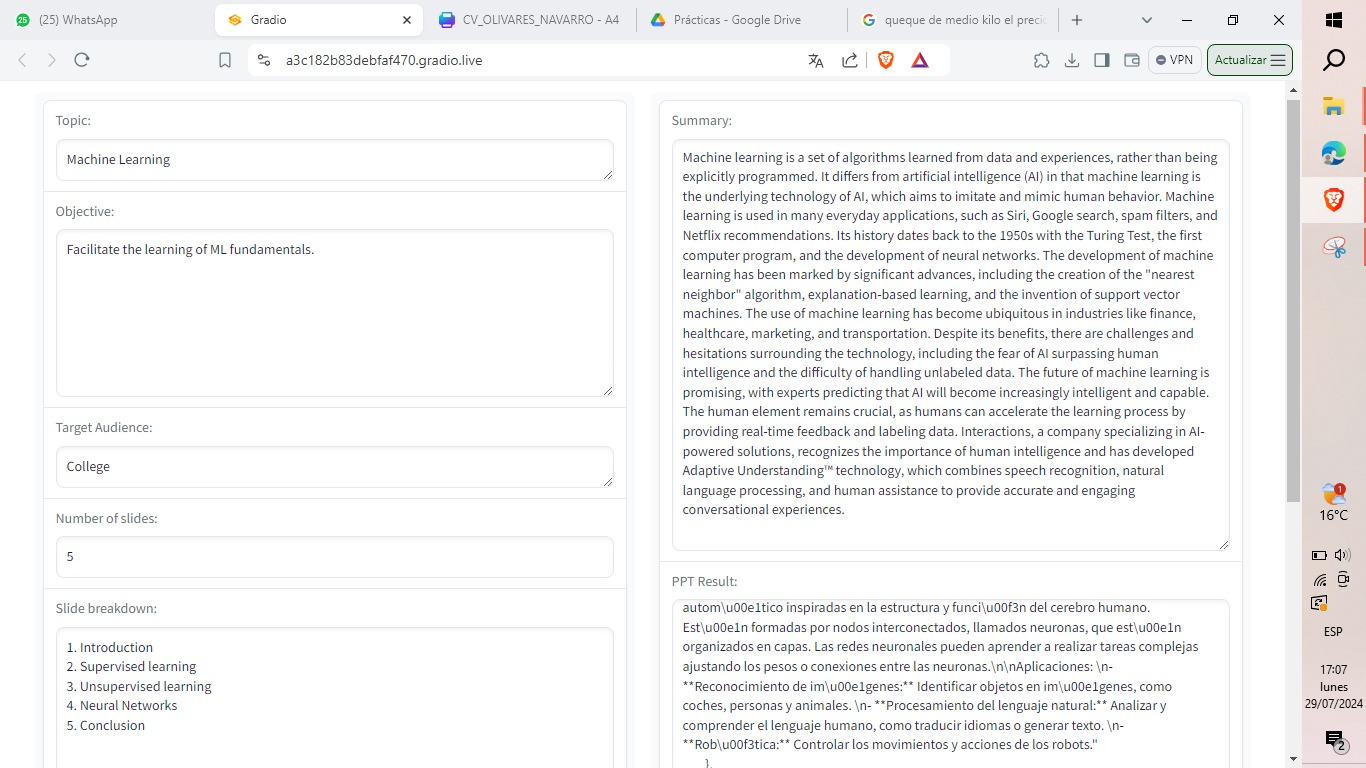

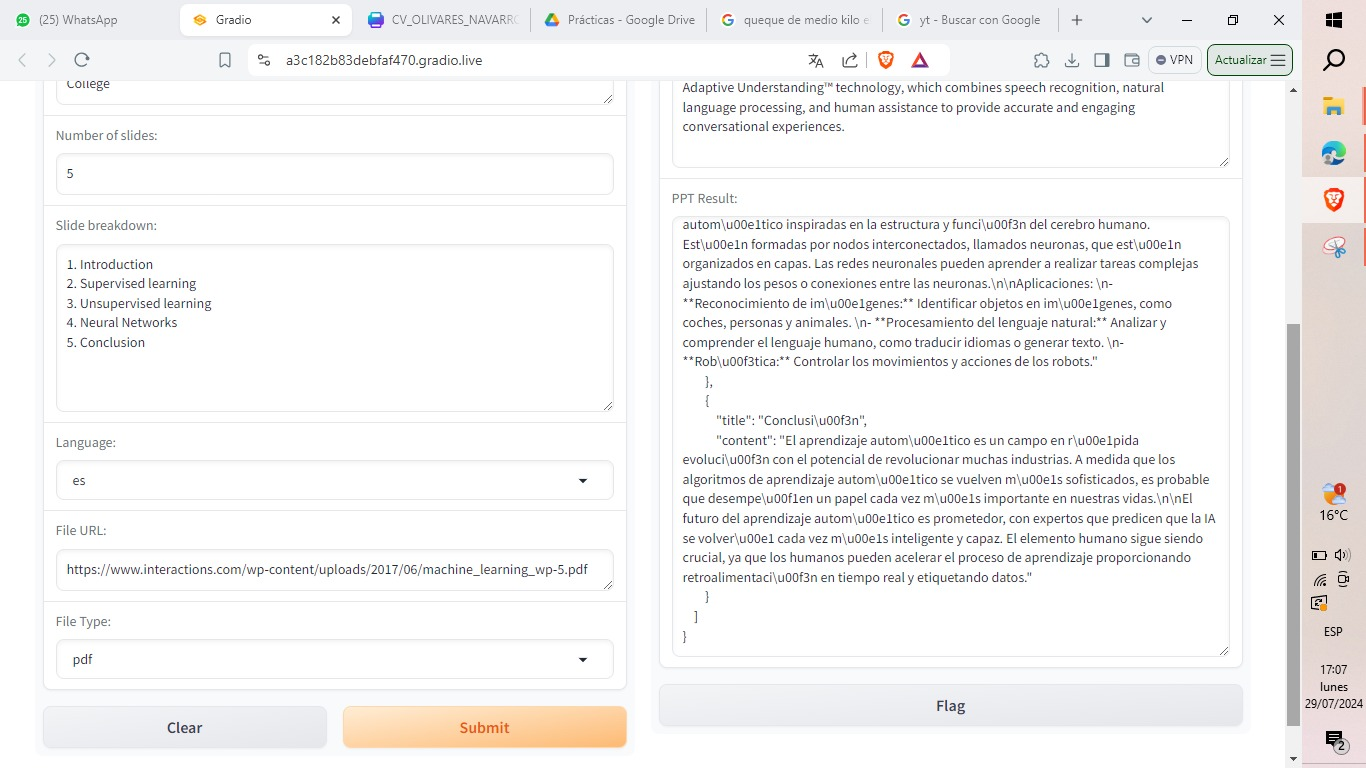

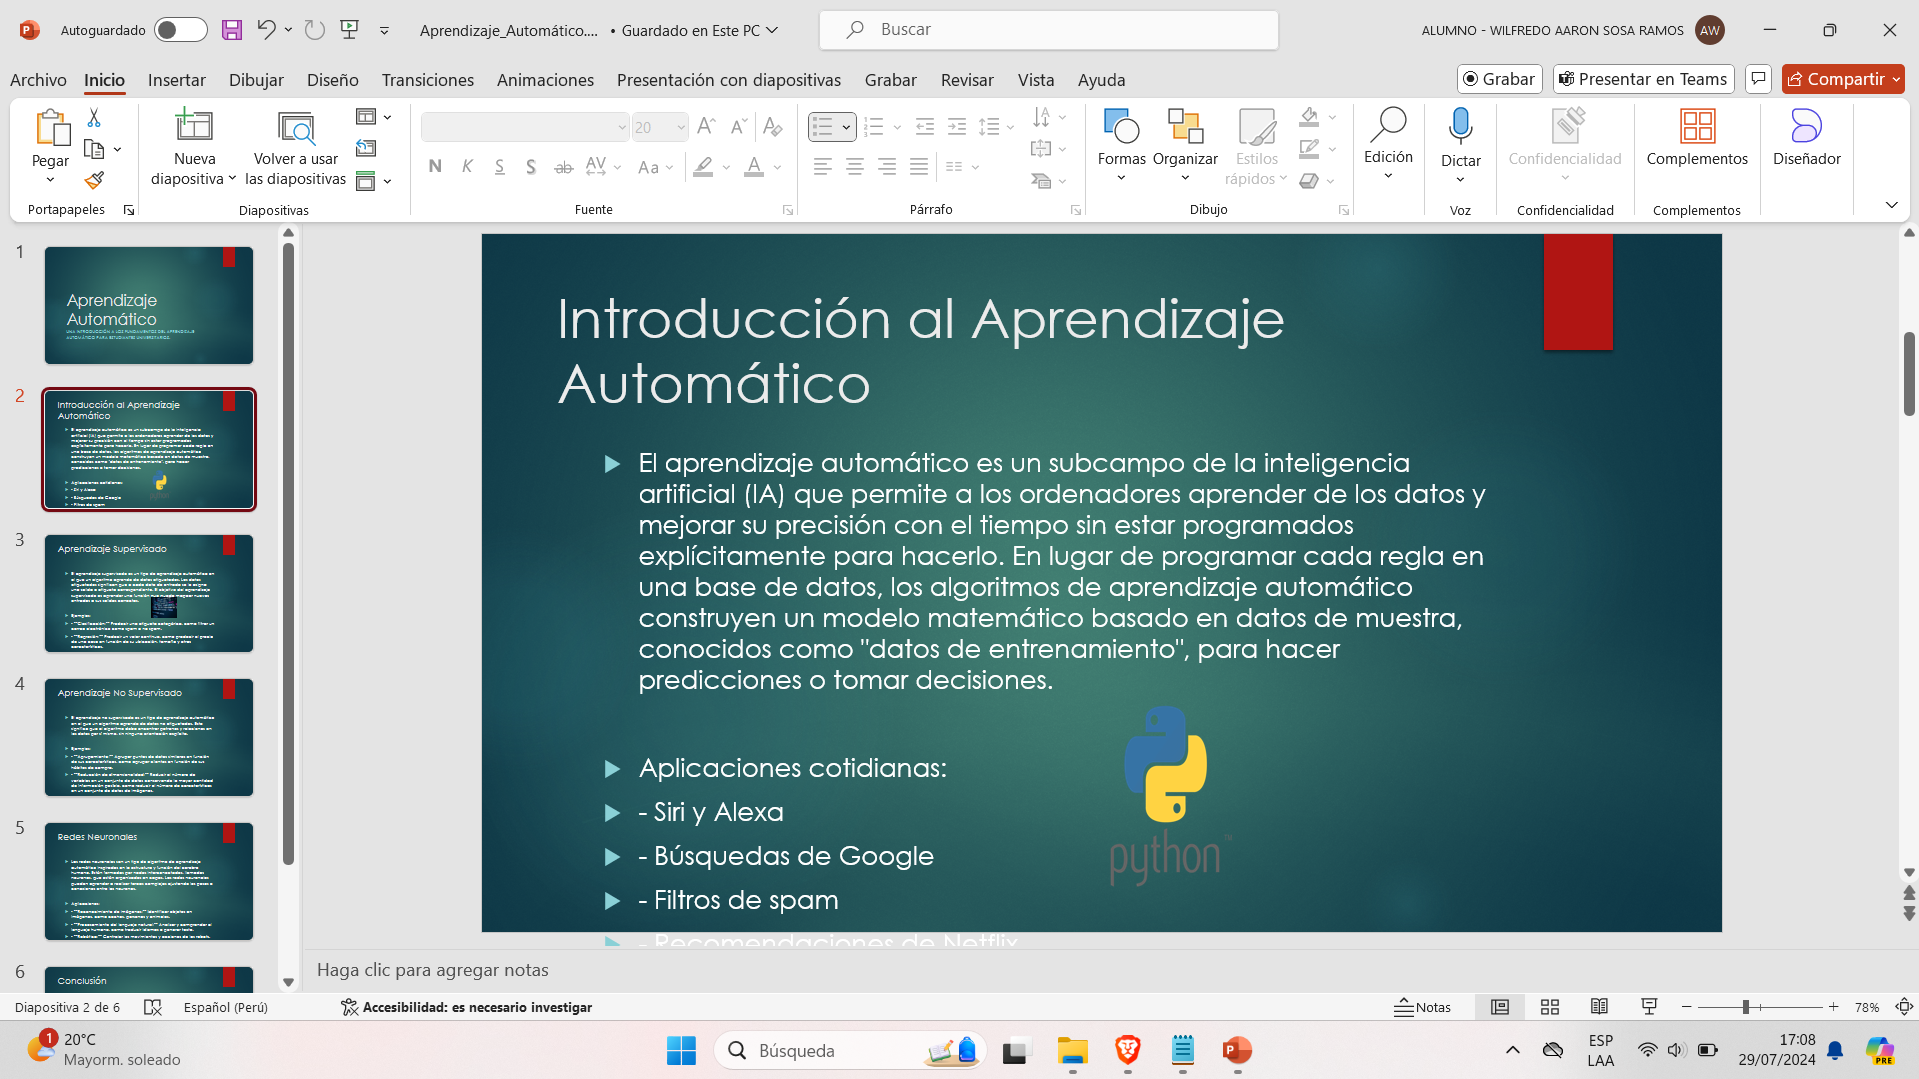

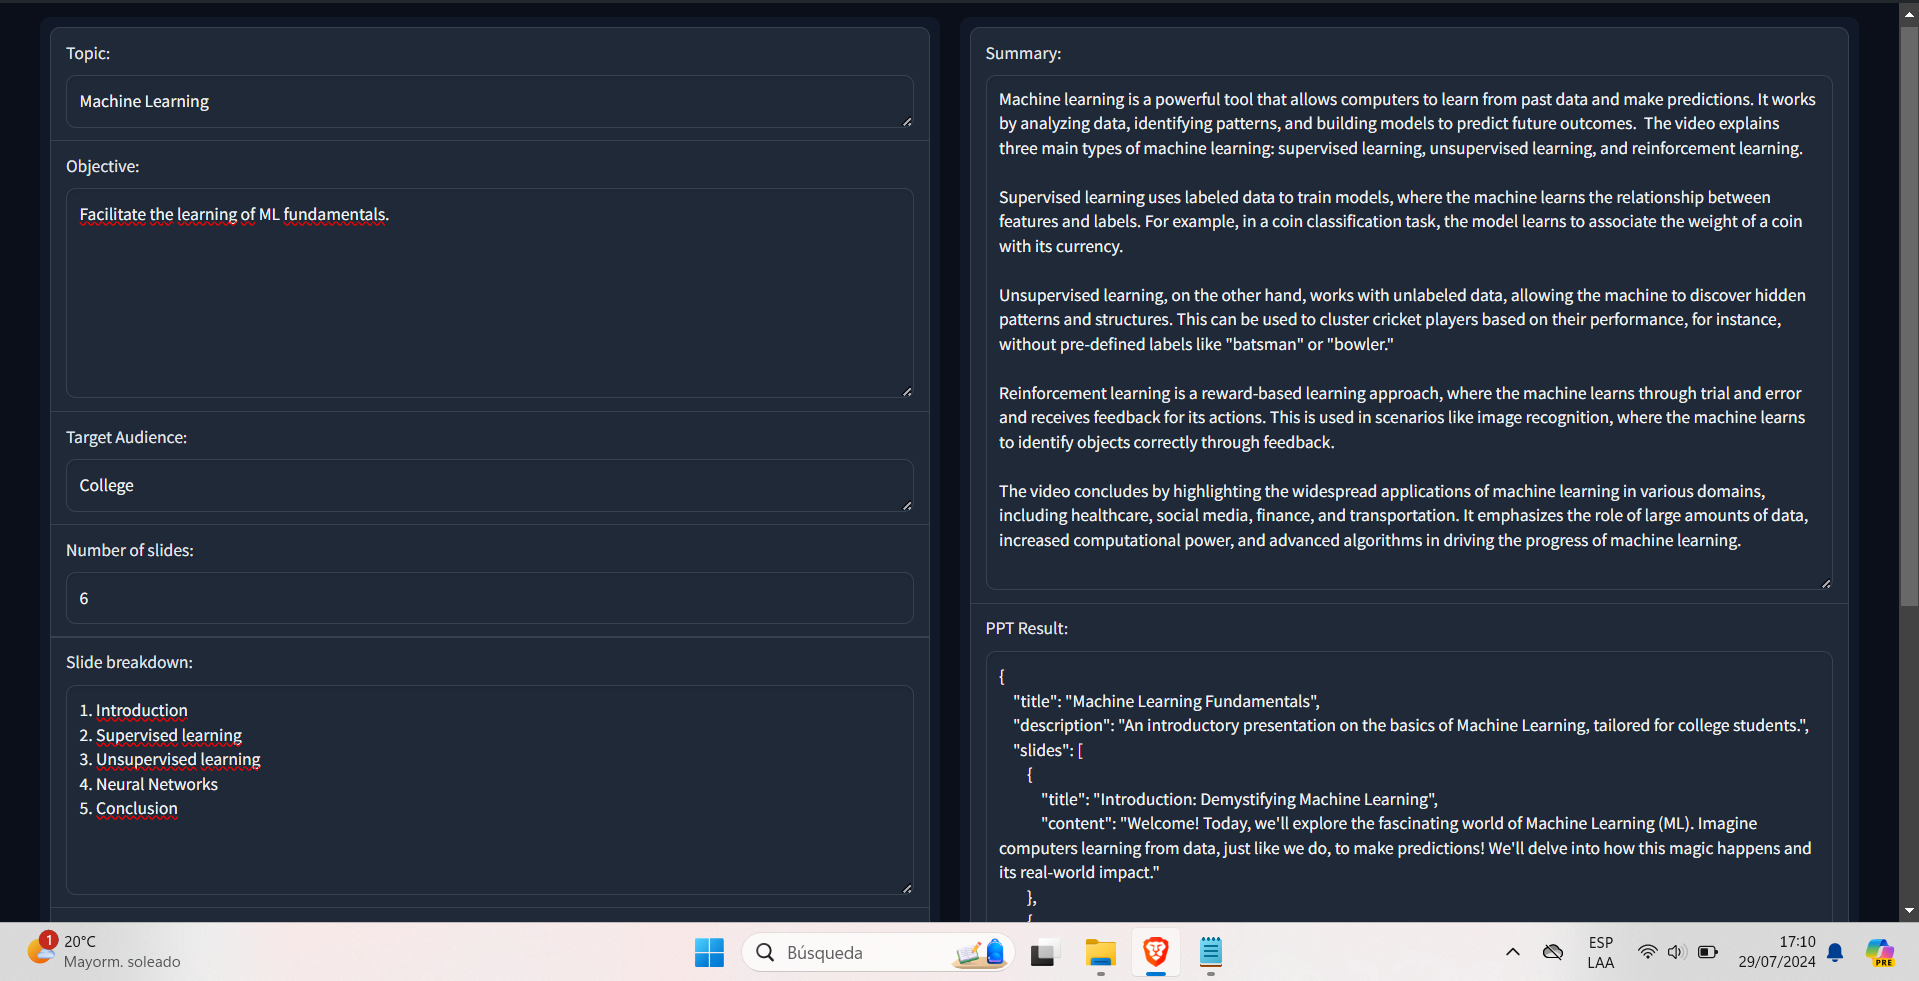

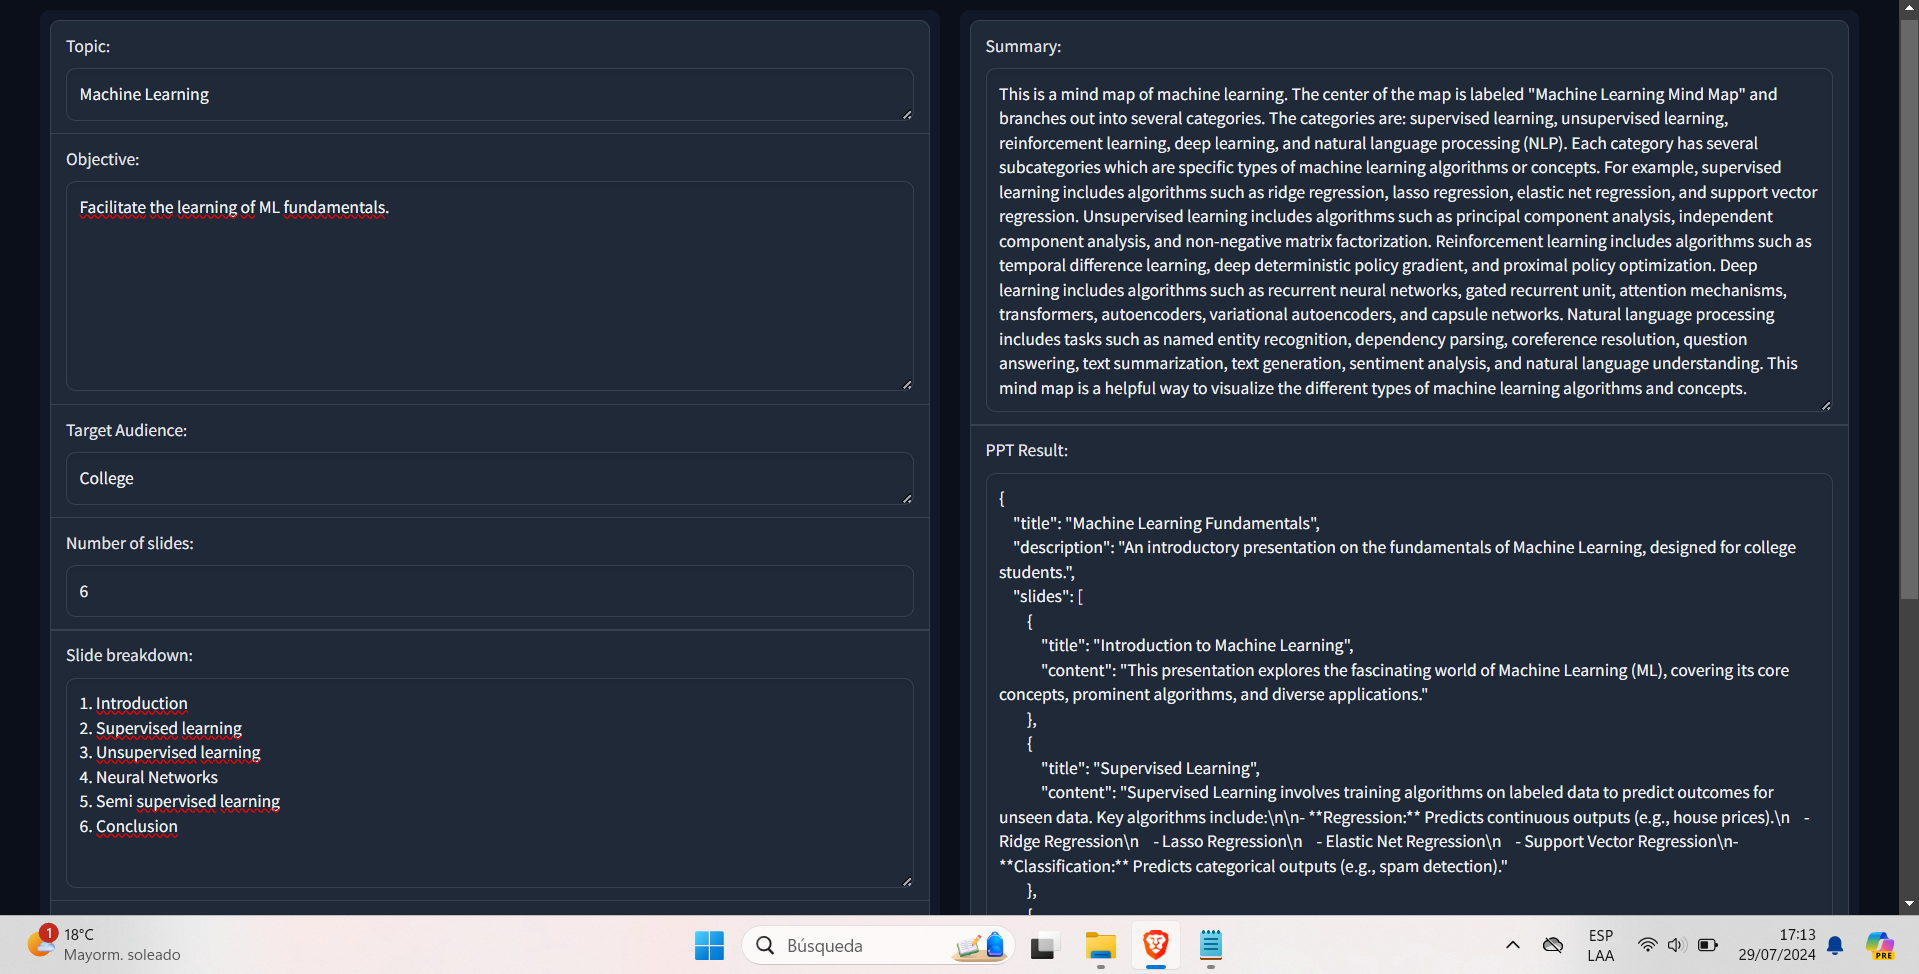